# Step #1 Blockchain Metadata

In [16]:
# Work in progress!
# A tutorial for this file will soon be available at www.relataly.com

# Tested with Python 3.9.13, Matplotlib 3.5.2, Seaborn 0.11.2, numpy 1.21.5, plotly 4.1.1, cryptocompare 0.7.6

import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates # Formatting dates
import matplotlib.ticker as ticker
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})
import cryptocompare as cc
import requests
import IPython
import yaml
import json
from PIL import Image

# Set the API Key 
yaml_file = open('API Keys/api_config_cryptocompare.yml', 'r')  
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key']
cc.cryptocompare._set_api_key_parameter(api_key)

# Request a list of coins available on cry# ptocompare
coinlist_dict = cc.get_coin_list()
crypto_list_df = pd.DataFrame.from_dict(coinlist_dict, orient='index', dtype=None, columns=None)
crypto_list_df['creation_date'] = pd.to_datetime(crypto_list_df['ContentCreatedOn'], unit='s').dt.date
crypto_list_df.drop(columns=['ContentCreatedOn', 'SortOrder', 'Name', 'FullName', 'Url', 'Id', 'Sponsored', 'AssetTokenStatus'], inplace=True)
crypto_list_df.head(3)

,ImageUrl,Symbol,CoinName,Description,Algorithm,ProofType,Taxonomy,Rating,creation_date
BTCD,/media/19630/btcd_1.png,BTCD,BitcoinDark,Bitcoin Dark (BTCD) is a PoW and PoS hybrid al...,SHA-256,PoW/PoS,"{'Access': 'Permissionless', 'FCA': 'Exchange'...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-03-30
CRAIG,/media/20022/craig.png,CRAIG,CraigsCoin,CraigCoin (CRAIG) is a 100% pure PoS or Proof ...,X11,PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-03-30
XBS,/media/351060/xbs_1.png,XBS,Bitstake,To create the infrastructure necessary to impl...,X11,PoW/PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-04-10


# Step #2 Correlation with Bitcoin Price Data

In [17]:
# Load price history
def load_crypto_price(symbol):
    historic_dict = cc.get_historical_price_day_from(symbol)
    df = pd.DataFrame(historic_dict)
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df['date_yearmonth'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
    df.drop(columns=['time', 'conversionType', 'conversionSymbol'])
    df.head()
    return df.sort_values(by='time', ascending=False).reset_index()

# Define coin symbols
symbol_a = 'BTC'
symbol_b = 'ETH'

# Load data
coin_a_price_df = load_crypto_price(symbol_a)
coin_b_price_df = load_crypto_price(symbol_b)
coin_b_price_df.head(3)

,index,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,date,date_yearmonth
0,2673,1669852800,1243.14,1204.22,1242.33,26219.33,3.207533e+07,1214.02,direct,,2022-12-01,2022-12
1,2672,1669766400,1251.53,1216.44,1178.35,147516.76,1.832845e+08,1242.47,multiply,BTC,2022-11-30,2022-11
2,2671,1669680000,1183.60,1143.95,1128.70,122781.89,1.446795e+08,1178.35,multiply,BTC,2022-11-29,2022-11


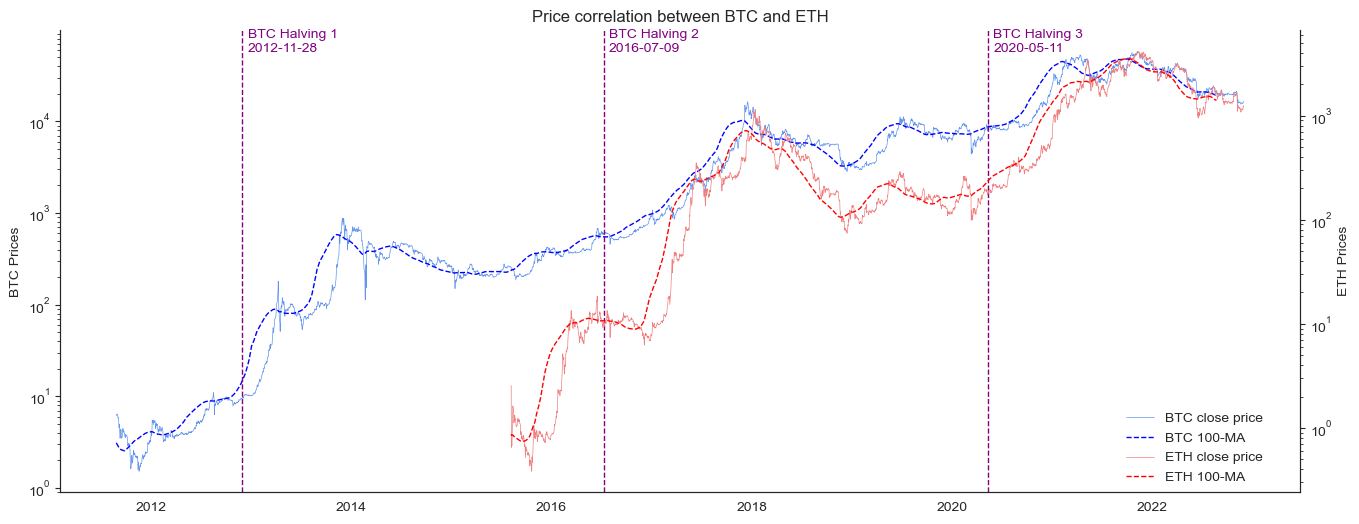

In [4]:
# Lineplot: Price Correlation with Bitcoin

# Adding moving averages
window = 100
coin_a_price_df['close_avg'] = coin_a_price_df['close'].rolling(window=window).mean() 
coin_b_price_df['close_avg'] = coin_b_price_df['close'].rolling(window=window).mean() 

# This function adds bitcoin halving dates as vertical lines
def add_halving_dates(ax, df_x_dates, df_ax1_y):
    halving_dates = ['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', '2024-03-12', '2028-06-01'] 
    dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in halving_dates]
    for i, datex in enumerate(dates_list):
        halving_ts = pd.Timestamp(datex)
        x_max = df_x_dates.max() + timedelta(days=365)
        x_min = df_x_dates.min() - timedelta(days=365)
        if (halving_ts < x_max) and (halving_ts > x_min):
            ax.axvline(x=datex, color = 'purple', linewidth=1, linestyle='dashed')
            ax.text(x=datex  + timedelta(days=20), y=df_ax1_y.max()*0.99, s='BTC Halving ' + str(i) + '\n' + str(datex), color = 'purple')

# This function creates a nice legend for twinx plots
def add_twinx_legend(ax1, ax2, x_anchor=1.18, y_anchor=1.0):
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=1, facecolor='white', framealpha=0, bbox_to_anchor=(x_anchor, y_anchor))
    ax2.get_legend().remove()

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=coin_a_price_df, x='date', y='close', color='cornflowerblue', linewidth=0.5, label=f'{symbol_a} close price', ax=ax1)
sns.lineplot(data=coin_a_price_df, x='date', y='close_avg', color='blue', linestyle='dashed', linewidth=1.0, 
    label=f'{symbol_a} {window}-MA', ax=ax1)
ax1.set_ylabel(f'{symbol_a} Prices')
ax1.set(xlabel=None)
ax2 = ax1.twinx()
sns.lineplot(data=coin_b_price_df, x='date', y='close', color='lightcoral', linewidth=0.5, label=f'{symbol_b} close price', ax=ax2)
sns.lineplot(data=coin_b_price_df, x='date', y='close_avg', color='red', linestyle='dashed', linewidth=1.0, 
    label=f'{symbol_b} {window}-MA', ax=ax2)
ax2.set_ylabel(f'{symbol_b} Prices')
add_twinx_legend(ax1, ax2, 0.98, 0.2)
add_halving_dates(ax1, coin_a_price_df.date, coin_a_price_df.close)
ax1.set_yscale('log'), ax2.set_yscale('log')
plt.title(f'Price correlation between {symbol_a} and {symbol_b}')
plt.show()

Text(0.5, 1.0, 'BTC-ETH correlation (rolling window=100)')

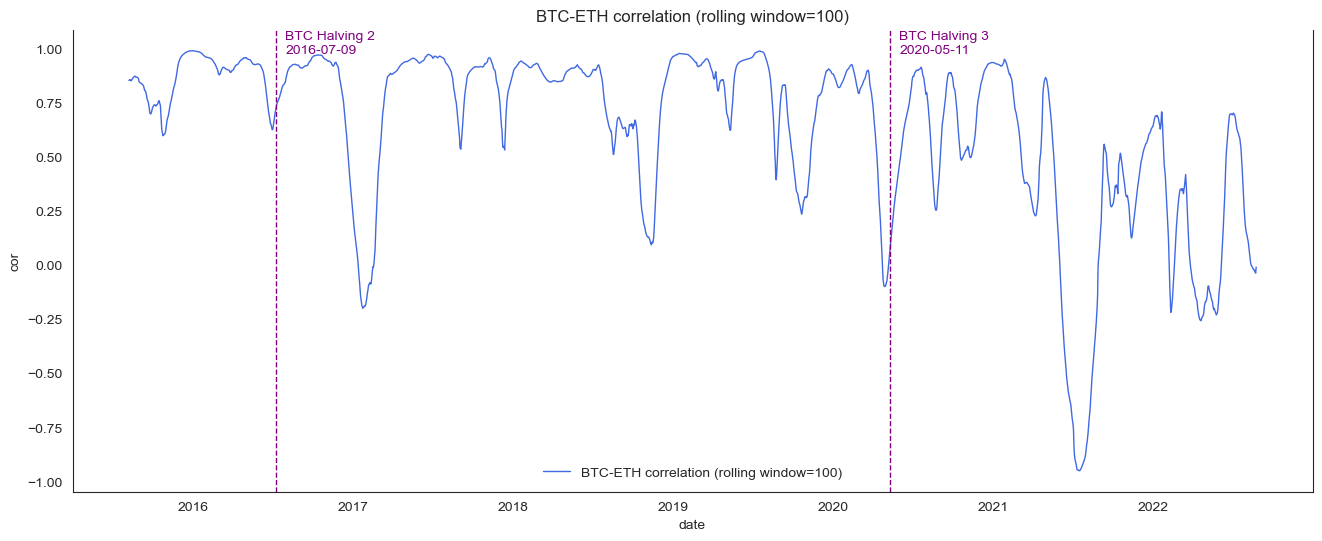

In [5]:
# Calculate the Rolling Correlation Coefficient
rolling_window = 100 #days

# Generate a work dataframe that includes closing prices and date
df_price_merged = pd.DataFrame.from_dict(data={f'close_{symbol_b}': coin_b_price_df['close'], f'close_{symbol_a}': coin_a_price_df['close'], 'date': coin_a_price_df['date']})
# Create the rolling correlation dataframe
df_temp = pd.DataFrame({'cor': coin_b_price_df.close.rolling(rolling_window).corr(coin_a_price_df.close).dropna()})
# Reverse the index and join the df to create a date index
df_cor_dateindex = df_price_merged.join(df_temp[::-1].set_index(df_temp.index)).dropna().set_index('date')

# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 6))
label = f'{symbol_a}-{symbol_b} correlation (rolling window={rolling_window})'
sns.lineplot(data=df_cor_dateindex, x=df_cor_dateindex.index, y='cor', color='royalblue', linewidth=1.0, label=label)
add_halving_dates(ax1, df_cor_dateindex.index, df_cor_dateindex[f'cor'])
plt.legend(framealpha=0)
plt.title(label)

# Step #3 Distribution by Holder Amount

In [6]:
# Load Historic Balance Distribution Data 
def get_balance_distribution_data(crypto_symbol, data_limit):
  url = f'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={crypto_symbol}&limit={data_limit}'

  headers = {
    'authorization': 'Apikey ' + api_key,
  }

  # API call to the cryptocompare blockchain historic data endpoint
  session = requests.Session()
  session.headers.update(headers)
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_flat = pd.json_normalize(json_struct)
  df_flat['date'] = pd.to_datetime(df['time'], unit='s')
  df_flat = pd.concat([df_flat.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_flat.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to', 'time'], inplace=True)

  # Data cleansing
  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

data_limit = 2000
symbol_a = 'BTC'
df_distr = get_balance_distribution_data(symbol_a, data_limit)
df_distr.head()

,date,totalVolume,addressesCount,range
0,2017-06-10,2.016926e+03,10309190.0,0.0_to_0.001
1,2017-06-10,1.187396e+04,3132619.0,0.001_to_0.01
2,2017-06-10,8.496660e+04,2745892.0,0.01_to_0.1
3,2017-06-10,3.960774e+05,1218992.0,0.1_to_1.0
4,2017-06-10,1.228393e+06,447067.0,1.0_to_10.0


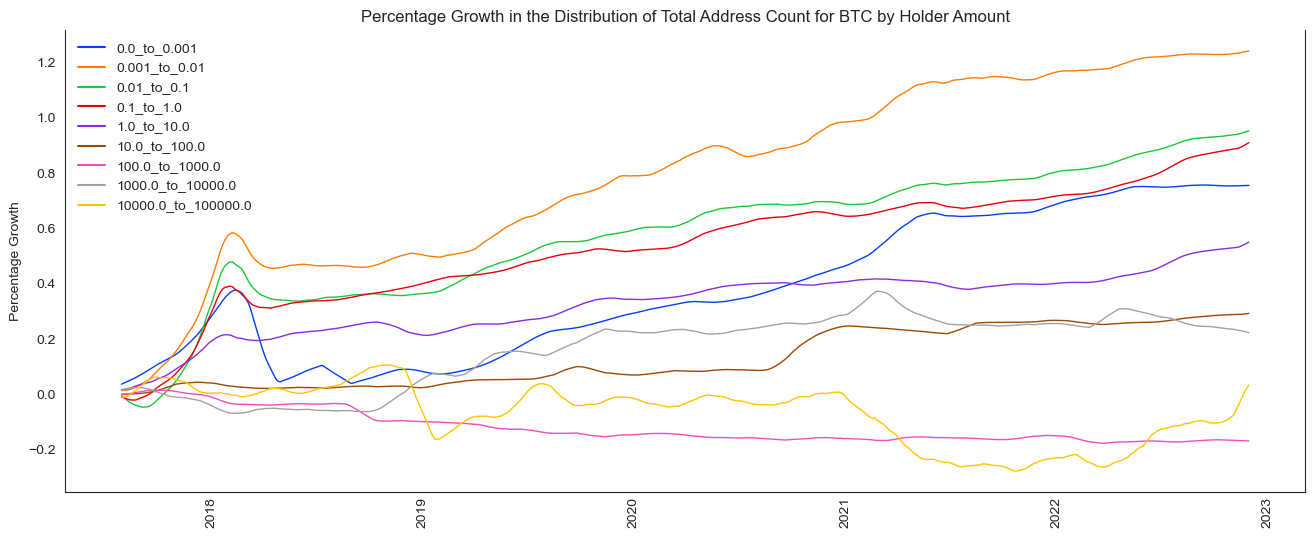

In [8]:
# Data preparation
df_distr_add = df_distr.copy()
for i in list(df_distr_add.range.unique()):
    df_distr_add.loc[df_distr.range == i, 'addressesCount_pct_cum'] = df_distr_add[df_distr_add.range == i]['addressesCount'].pct_change().dropna().cumsum().rolling(window=50).mean()
df_distr_add.dropna(inplace=True)

# Lineplot: Address Count by Holder Amount
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=df_distr_add, x='date', hue='range', linewidth = 1.0, y='addressesCount_pct_cum', ax=ax1, palette='bright')
plt.ylabel('Percentage Growth')
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.set(xlabel=None)
plt.title(f'Percentage Growth in the Distribution of Total Address Count for {symbol_a} by Holder Amount')
plt.legend(framealpha=0)
plt.show()

# Step #4 Network Security & Health

In [9]:
# Load Historic OnChain Data

def get_onchain_data(crypto_symbol, data_limit):
  url = f'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym={crypto_symbol}&limit={data_limit}'

  headers = {
    'authorization': 'Apikey ' + api_key,
  }

  # API call to the cryptocompare blockchain historic data endpoint
  session = requests.Session()
  session.headers.update(headers)
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns='time', inplace=True)
  return df

# Query on-chain data
data_limit = 2000
onchain_symbol_a_df = get_onchain_data(symbol_a, data_limit)
onchain_symbol_b_df = get_onchain_data(symbol_b, data_limit)

# Filter some faulty values
onchain_symbol_a_df = onchain_symbol_a_df[onchain_symbol_a_df['hashrate'] > 0.0]
onchain_symbol_a_df.head(3)

,id,symbol,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply,date
0,1182,BTC,252953066,270956035,357663,705037,254993,230888380,11995,9.604650,470727,4.807078e+06,6.787601e+11,606.450000,966455,1.638409e+07,2017-06-10
1,1182,BTC,253283127,271274040,318005,669902,222892,231111272,11649,10.325782,470873,4.932055e+06,6.787601e+11,591.082759,945474,1.638591e+07,2017-06-11
2,1182,BTC,253638108,271660372,386332,725777,269098,231380370,12090,10.752733,471020,5.033014e+06,6.787601e+11,579.226027,967594,1.638775e+07,2017-06-12


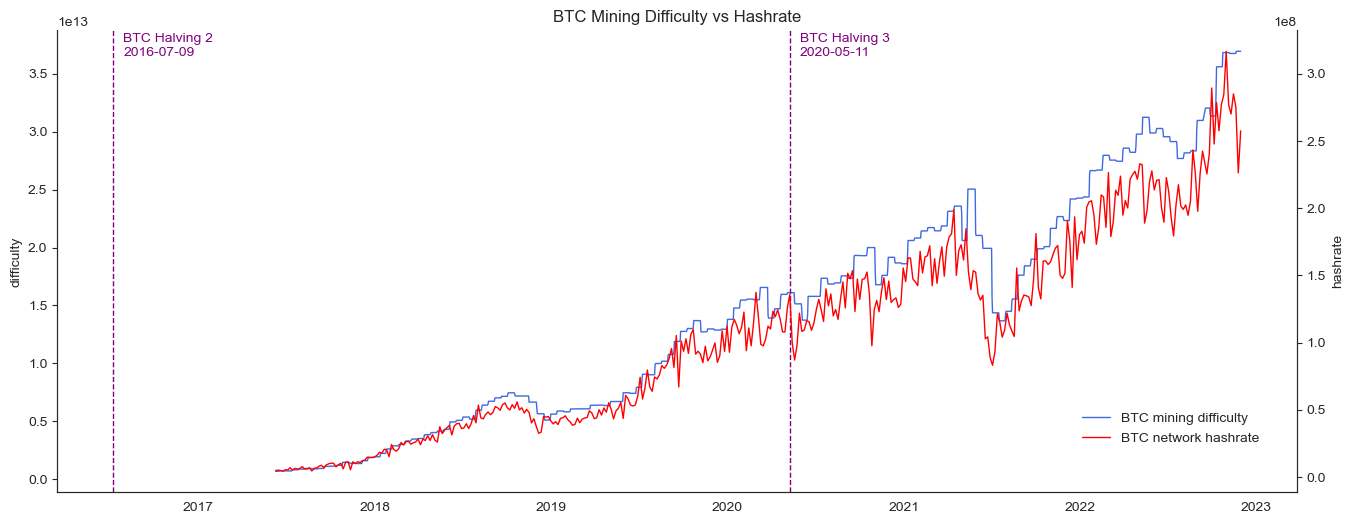

In [10]:
# Lineplot: Difficulty vs Hashrate
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df, x='date', y='difficulty', 
    linewidth=1.0, color='royalblue', ax=ax1, label=f'{symbol_a} mining difficulty')
ax2 = ax1.twinx()
sns.lineplot(data=onchain_symbol_a_df[::5], x='date', y='hashrate', 
    linewidth=1.0, color='red', ax=ax2, label=f'{symbol_a} network hashrate')
add_twinx_legend(ax1, ax2, 0.98, 0.2)
add_halving_dates(ax1, onchain_symbol_a_df.date, onchain_symbol_a_df.difficulty)
ax1.set(xlabel=None)
plt.title(f'{symbol_a} Mining Difficulty vs Hashrate')
plt.show()

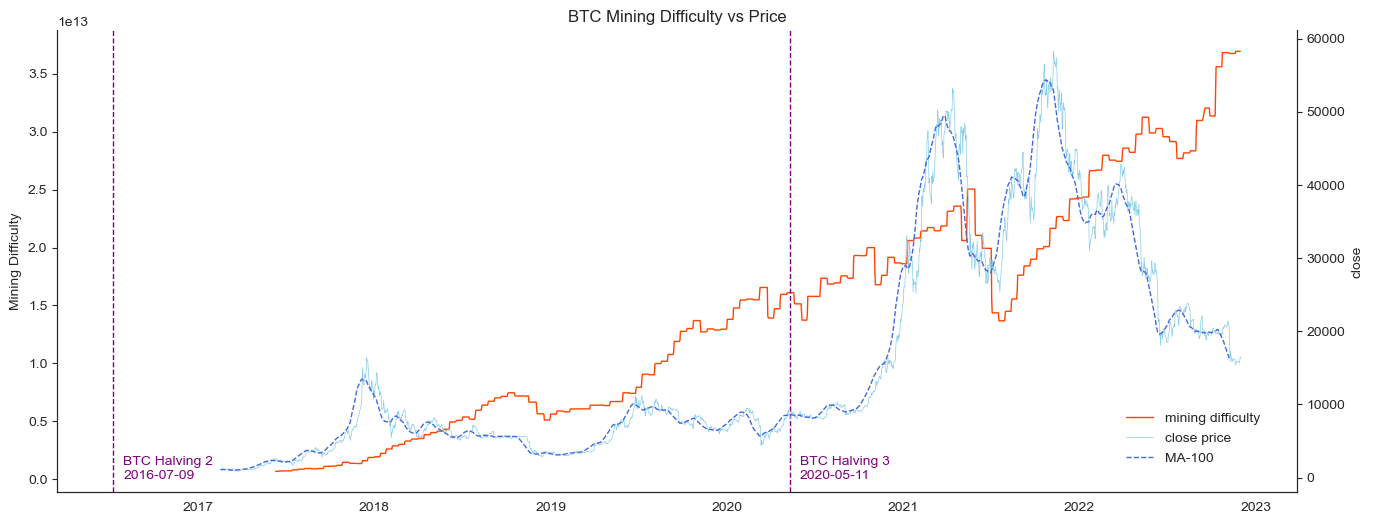

In [11]:
# Mining Difficulty vs Price
coin_a_price_df['close_avg'] = coin_a_price_df['close'].rolling(window=25).mean() 

# Creating a Lineplot: Mining Difficulty vs Price
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df, x='date', y='difficulty', linewidth=1.0, color='orangered', ax=ax1, label=f'mining difficulty')
ax2 = ax1.twinx()
sns.lineplot(data=coin_a_price_df[:-2000], x='date', y='close', linewidth=0.5, color='skyblue', ax=ax2, label=f'close price')
sns.lineplot(data=coin_a_price_df[:-2000], x='date', y='close_avg', linewidth=1.0, linestyle='--', color='royalblue', ax=ax2, label=f'MA-100')
add_twinx_legend(ax1, ax2, 0.98, 0.2)
add_halving_dates(ax1, onchain_symbol_a_df.date, onchain_symbol_a_df.hashrate)
ax1.set(xlabel=None)
ax1.set(ylabel='Mining Difficulty')
plt.title(f'{symbol_a} Mining Difficulty vs Price')
plt.show()

# Step #5 Network Growth and Usage

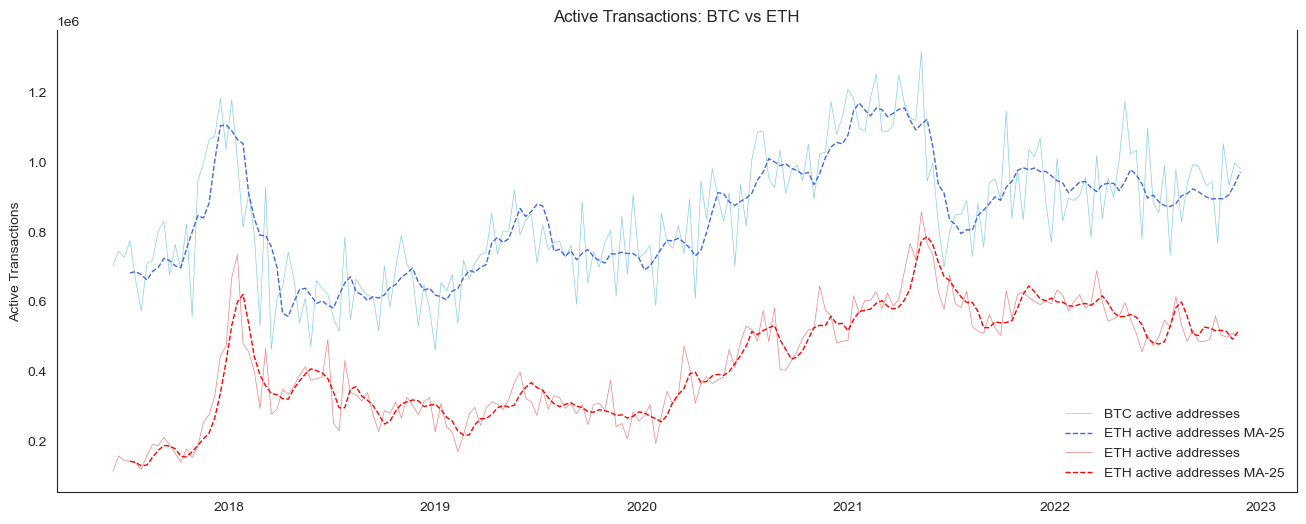

In [12]:
# Network Growth and Usage
window=25
onchain_symbol_a_df['active_addresses_avg'] = onchain_symbol_a_df['active_addresses'].rolling(window=window).mean() 
onchain_symbol_b_df['active_addresses_avg'] = onchain_symbol_b_df['active_addresses'].rolling(window=window).mean() 

# Lineplot: Active Transactions
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='active_addresses', 
    linewidth=0.5, color='skyblue', ax=ax1, label=f'{symbol_a} active addresses')
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='active_addresses_avg', 
    linewidth=1.0, color='royalblue', linestyle='--', ax=ax1, label=f'{symbol_b} active addresses MA-{window}')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='active_addresses', 
    linewidth=0.5, color='lightcoral', ax=ax1, label=f'{symbol_b} active addresses')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='active_addresses_avg', 
    linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{symbol_b} active addresses MA-{window}')
ax1.set(xlabel=None)
ax1.set(ylabel='Active Transactions')
plt.title(f'Active Transactions: {symbol_a} vs {symbol_b}')
plt.legend(framealpha=0)
plt.show()

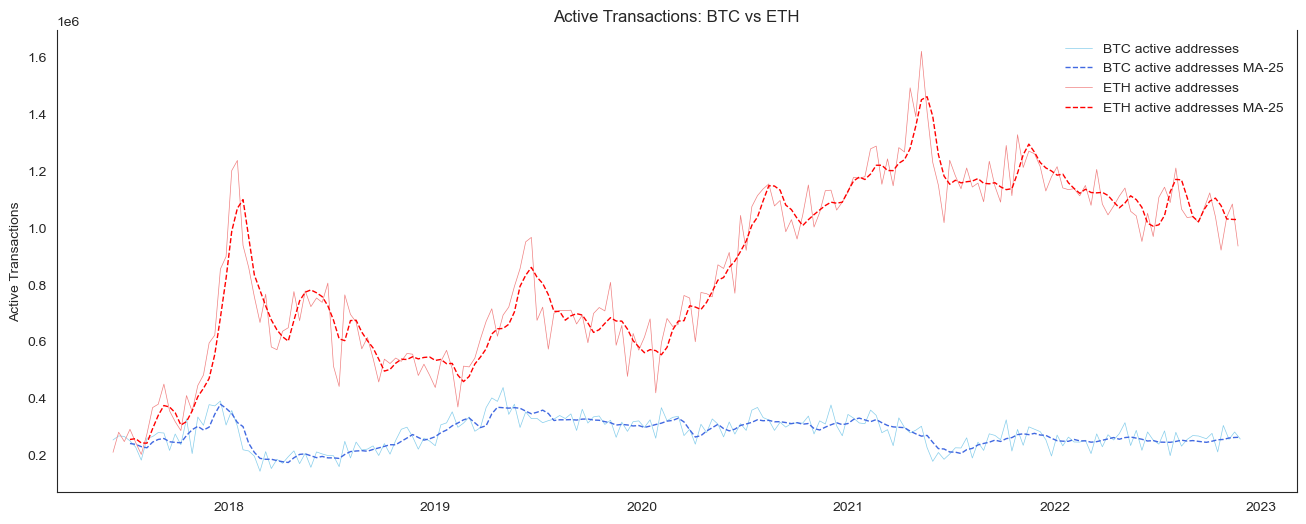

In [13]:
# Active Transactions
window=25
onchain_symbol_a_df['transaction_count_avg'] = onchain_symbol_a_df['transaction_count'].rolling(window=window).mean() 
onchain_symbol_b_df['transaction_count_avg'] = onchain_symbol_b_df['transaction_count'].rolling(window=window).mean() 

# Lineplot: Active Transactions
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='transaction_count', 
    linewidth=0.5, color='skyblue', ax=ax1, label=f'{symbol_a} active addresses')
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='transaction_count_avg', 
    linewidth=1.0, color='royalblue', linestyle='--', ax=ax1, label=f'{symbol_a} active addresses MA-{window}')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='transaction_count', 
    linewidth=0.5, color='lightcoral', ax=ax1, label=f'{symbol_b} active addresses')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='transaction_count_avg', 
    linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{symbol_b} active addresses MA-{window}')
ax1.set(xlabel=None)
ax1.set(ylabel='Active Transactions')
plt.legend(framealpha=0)
plt.title(f'Active Transactions: {symbol_a} vs {symbol_b}')
plt.show()

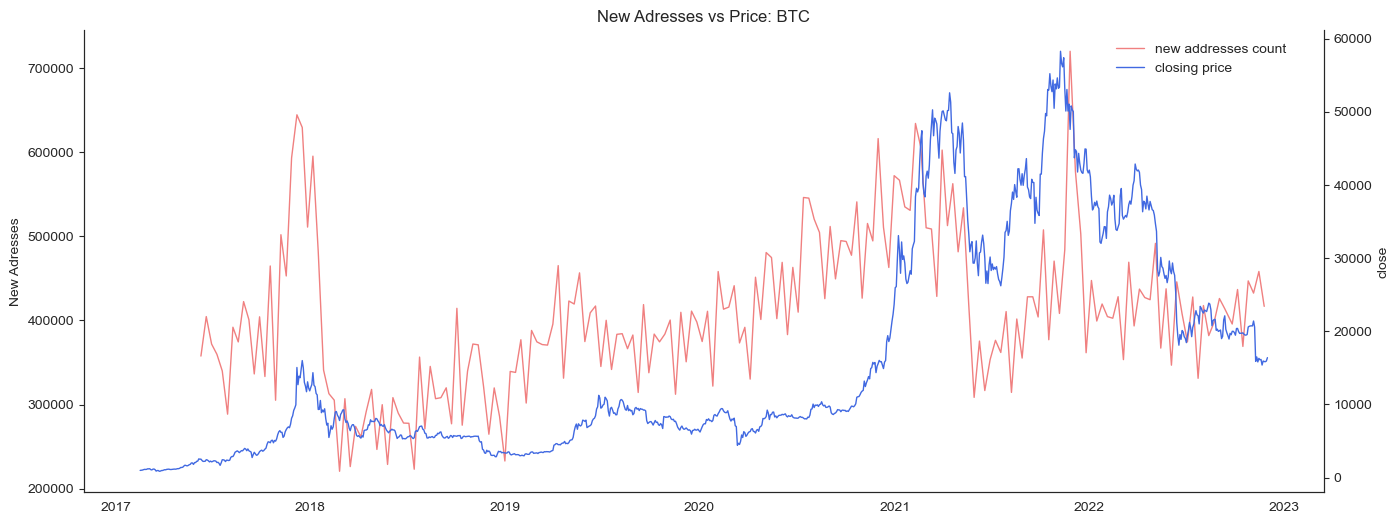

In [14]:
# Lineplot: Active Adresses
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df[::10], x='date', y='new_addresses', 
    linewidth=1.0, color='lightcoral', ax=ax1, label=f'new addresses count')
ax2  = ax1.twinx()
sns.lineplot(data=coin_a_price_df[:-data_limit:2], x='date', y='close', 
    linewidth=1.0, color='royalblue', ax=ax2, label=f'closing price')
ax1.set(xlabel=None)
ax1.set(ylabel='New Adresses')
add_twinx_legend(ax1, ax2, 0.98, 1.0)
plt.title(f'New Adresses vs Price: {symbol_a}')
plt.show()

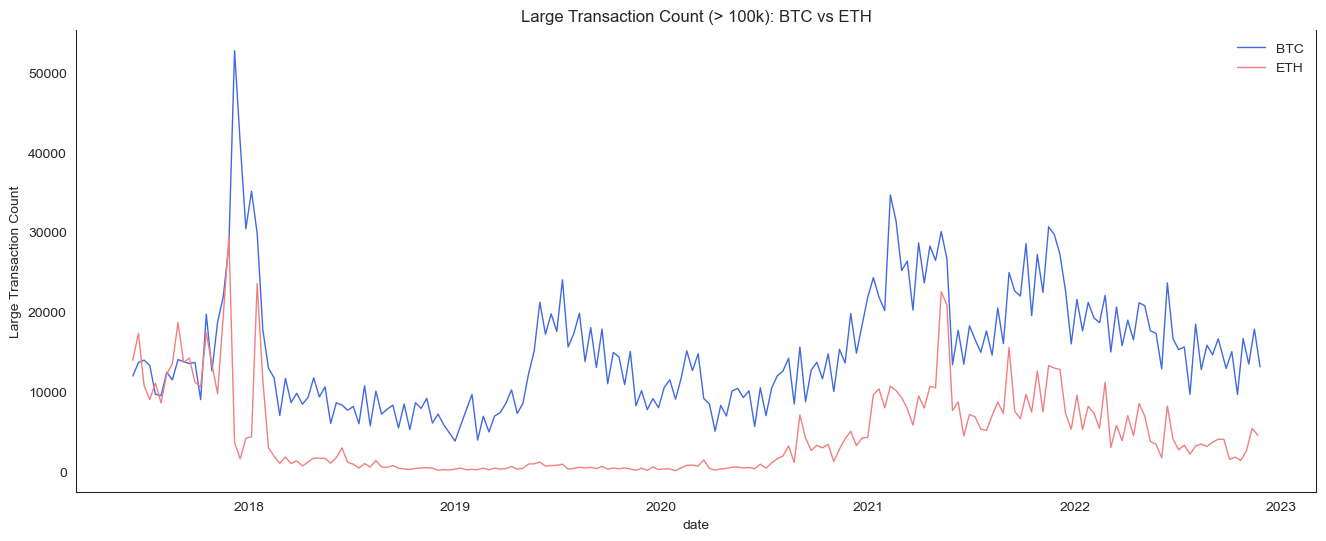

In [15]:
# Lineplot: Large Transactions
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_symbol_a_df[-1*data_limit::10], x='date', y='large_transaction_count', 
    linewidth=1.0, color='royalblue', ax=ax1, label=f'{symbol_a}')
sns.lineplot(data=onchain_symbol_b_df[-1*data_limit::10], x='date', y='large_transaction_count', 
    linewidth=1.0, color='lightcoral', ax=ax1, label=f'{symbol_b}') 
ax1.set(ylabel='Large Transaction Count')
plt.title(f'Large Transaction Count (> 100k): {symbol_a} vs {symbol_b}')
plt.legend(framealpha=0)
plt.show()